# Import module

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display
import imageio

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Para

In [3]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000
DATASET_SIZE = 70495*3

SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

CAPTION_NUM = 70495

IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

In [4]:
hparas = {
    'EMBED_DIM': 1024,                         # word embedding dimension
    'Z_DIM': 256,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 256,
    'LR': 1e-4,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'N_EPOCH': 600,
    'N_SAMPLE': DATASET_SIZE // BATCH_SIZE,          # size of training data
    'rs_Train': float(BATCH_SIZE) / float(DATASET_SIZE), 
    'CHECKPOINTS_DIR': './checkpoints/train',  # checkpoint path
    'PRINT_FREQ': 1,                       # printing frequency of loss
    'BZ':(BATCH_SIZE,256),
    'TEST_Z':(SAMPLE_NUM,256),
    'TEST_BATCH_SIZE':91
}

### data preprocessing

In [21]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [ ]:
def idx2word(indices_list):
    results_list = []
    for indices in indices_list:
        string = ''
        length_of_string = 0
        for idx in indices:
            if idx == '5428':
                string = string + ''
            elif idx == '5427':
                break
            else:
                string = string + id2word_dict[idx] + ' '
        results_list.append(string.strip())
    return results_list

In [21]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


In [54]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
df = pd.read_pickle(data_path + '/123.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [55]:
df.head(5)

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [50]:
df = df.reset_index(drop=True)
df['texts'] = df['Captions'].apply(lambda x: idx2word(x))

In [51]:
def remove_empty_string(string_list):
    empty_flag = False
    for string in string_list:
        if string == '':
            empty_flag = True
            break
    if empty_flag == False:
        return string_list
    else:
        new_string_list = []
        for string in string_list:
            if string != '':
                new_string_list.append(string)
        return new_string_list       

In [52]:
df['texts'] = df['texts'].apply(lambda x: remove_empty_string(x))

In [25]:
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained(
    'bert-large-uncased', 
    do_lower_case=False,
    do_basic_tokenize=False
)
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [26]:
def turn_to_bert_embedding(string_list):
    try:
        bert_inputs = bert_tokenizer(string_list, return_tensors="tf", padding='max_length',max_length=30)
        bert_outputs = bert_model(bert_inputs)
        caption_embedding = bert_outputs.last_hidden_state[:,0]
    except(ValueError):
        print(string_list)
    return caption_embedding.numpy().tolist()

In [40]:
from datetime import datetime

print("{}, start infering.".format(datetime.now()))
emb = df['texts'].apply(lambda x : turn_to_bert_embedding(x))
print("{}, end infering.".format(datetime.now()))

2022-12-16 16:25:53.885435, start infering.
2022-12-16 16:51:40.364406, end infering.


In [42]:
emb.to_pickle("./dataset/embedding.pkl")

In [43]:
df['ImagePath'].to_pickle("./dataset/imagepath.pkl")

In [25]:
df['Captions'].to_pickle("./dataset/caption.pkl")

# Define model and useeful function

In [5]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(image_path, embedding):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=[64, 64])
    img = tf.cast(img,tf.float32)
    img = img / 255.
    img = img*2. - 1.
    
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding

def flip_right_left_data_generator(image_path, embedding):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=[64, 64])
    img = tf.cast(img,tf.float32)
    img = img / 255.
    img = img*2. - 1.
    img = tf.image.flip_left_right(img)
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding


def adjust_brightness_data_generator(image_path, embedding):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=[64, 64])
    img = tf.cast(img,tf.float32)
    img = img / 255.
    img = tf.image.random_brightness(img, 0.2, 2)
    img = img*2. -1.
    img = tf.image.flip_up_down(img)
    embedding = tf.cast(embedding, tf.float32)

    return img, embedding

In [6]:
# Utility function
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out

In [7]:
class Generator(tf.keras.Model):
    """
    Generate fake image based on given text(hidden representation) and noise z
    input: text and noise
    output: fake image with size 64*64*3
    """
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas
        self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.to_4_4_1024 = tf.keras.layers.Dense(4*4*1024)
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        
        self.lr1 = tf.keras.layers.LeakyReLU()
        self.lr2 = tf.keras.layers.LeakyReLU()
        self.lr3 = tf.keras.layers.LeakyReLU()
        self.lr4 = tf.keras.layers.LeakyReLU()
        self.lr5 = tf.keras.layers.LeakyReLU()
        
        self.dc1 = tf.keras.layers.Conv2DTranspose(
            filters = 512,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc2 = tf.keras.layers.Conv2DTranspose(
            filters = 256,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc3 = tf.keras.layers.Conv2DTranspose(
            filters = 128,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        self.dc4 = tf.keras.layers.Conv2DTranspose(
            filters = 3,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        )
        
        
    def call(self, noise_z, text, training):
        # compress the embedding
        text = self.compress(text)
        text = self.lr1(text)
        
        # concatenate input text and random noise
        text_concat = tf.concat([noise_z, text], axis=1)
        
        # To 4*4*1024
        text_concat = self.to_4_4_1024(text_concat)
        text_concat = tf.reshape(text_concat, [-1, 4, 4, 1024])
        text_concat = self.bn1(text_concat,training=training)
        text_concat = self.lr2(text_concat)
        
        # To 8*8*512
        text_concat = self.dc1(text_concat)
        text_concat = self.bn2(text_concat,training=training)
        text_concat = self.lr3(text_concat)
        
        # To 16*16*256
        text_concat = self.dc2(text_concat)
        text_concat = self.bn3(text_concat,training=training)
        text_concat = self.lr4(text_concat)
        
        # To 32*32*128
        text_concat = self.dc3(text_concat)
        text_concat = self.bn4(text_concat,training=training)
        text_concat = self.lr5(text_concat)
        
        # To 64*64*3
        text_concat = self.dc4(text_concat)
        
        output = tf.nn.tanh(text_concat)
        
        return output

In [8]:
class Discriminator(tf.keras.Model):
    """
    Differentiate the real and fake image
    input: image and corresponding text
    output: labels, the real image should be 1, while the fake should be 0
    """
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.compress = tf.keras.layers.Dense(self.hparas['DENSE_DIM'])
        self.d = tf.keras.layers.Dense(1)
        
        self.relu = tf.keras.layers.ReLU()
        self.relu2 = tf.keras.layers.ReLU()
        
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.bn5 = tf.keras.layers.BatchNormalization()
        
        self.lr1 = tf.keras.layers.LeakyReLU()
        self.lr2 = tf.keras.layers.LeakyReLU()
        self.lr3 = tf.keras.layers.LeakyReLU()
        self.lr4 = tf.keras.layers.LeakyReLU()
        self.lr5 = tf.keras.layers.LeakyReLU()
        
        
        self.conv1 = tf.keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = (64,64,3))
        
        self.conv2 = tf.keras.layers.Conv2D(
            filters = 256,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv3 = tf.keras.layers.Conv2D(
            filters = 512,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv4 = tf.keras.layers.Conv2D(
            filters = 1024,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME")
        
        self.conv5 = tf.keras.layers.Conv2D(
            filters = 1024,
            kernel_size = 1,
            strides = (1, 1),
            padding = "SAME")
    
    def call(self, img, text, training):
        # Conpress embedding
        text = self.compress(text)
        text = self.relu(text)
        # To 32*32*128
        img = self.conv1(img)
        #img = self.bn1(img,training=training)
        img = self.lr1(img)
        # To 16*16*256
        img = self.conv2(img)
        #img = self.bn2(img,training=training)
        img = self.lr2(img)
        # To 8*8*512
        img = self.conv3(img)
        #img = self.bn3(img,training=training)
        img = self.lr3(img)
        # To 4*4*1024
        img = self.conv4(img)
        #img = self.bn4(img,training=training)
        img = self.lr4(img)
        
        # concatenate image with paired text
        text = tf.expand_dims(text,axis=1)
        text = tf.expand_dims(text,axis=1)
        text = tf.tile(text,multiples=[1,4,4,1])
        img_text = tf.concat([img, text], axis=-1)
        
        img_text = self.conv5(img_text)
        #img_text = self.bn5(img_text,training=training)
        img_text = self.relu2(img_text)
        
        img_text = tf.reshape(img_text, [-1, 4*4*1024])
        
        
        score = self.d(img_text)
        return score

In [9]:
generator = Generator(hparas)
discriminator = Discriminator(hparas)

In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_logits, fake_logits):
    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'])

In [13]:
@tf.function
def DC_D_Train(c1,embed,noise_decay):
    z = tf.random.normal(hparas['BZ']) 

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_2:
            x_bar = generator(z, embed, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise_decay * tf.random.normal(x_bar.shape)
            x = x + noise_decay * tf.random.normal(x.shape)
            x_hat = x_hat + noise_decay * tf.random.normal(x_hat.shape)

            z0 = discriminator(x_bar, embed, training = True)
            z1 = discriminator(x, embed, training = True)
            z2 = discriminator(x_hat, embed, training = True)

            gradient_penalty = tp_2.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_d = tp.gradient(ld, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradient_d, discriminator.trainable_variables))

    return lg, ld

@tf.function
def DC_G_Train(c1,embed,noise_decay):
    
    z = tf.random.normal(hparas['BZ'])

    with tf.GradientTape() as tp:
        with tf.GradientTape() as tp_2:
            x_bar = generator(z, embed, training = True)
            epsilon = tf.random.uniform([BATCH_SIZE,1,1,1])
            x = c1
            x_hat = epsilon * x + (1. - epsilon) * x_bar

            x_bar = x_bar + noise_decay * tf.random.normal(x_bar.shape)
            x = x + noise_decay * tf.random.normal(x.shape)
            x_hat = x_hat + noise_decay * tf.random.normal(x_hat.shape)

            z0 = discriminator(x_bar, embed, training = True)
            z1 = discriminator(x, embed, training = True)
            z2 = discriminator(x_hat, embed, training = True)
            gradient_penalty = tp_2.gradient(z2,x_hat)
            gradient_penalty = tf.sqrt(tf.reduce_sum(tf.math.square(gradient_penalty),axis=[1,2,3]))
            loss = z0 - z1 + 10. * tf.math.square((gradient_penalty - 1.))
            ld = tf.reduce_mean(loss)
            lg = - tf.reduce_mean(z0)

    gradient_g = tp.gradient(lg, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradient_g, generator.trainable_variables))

    return lg, ld

In [14]:
@tf.function
def test_step(noise, embed):
    fake_image = generator(noise, embed, training = False)
    return fake_image

### Training *

In [15]:
Train = (
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_D_Train,
    DC_G_Train
)

Critic = len(Train)

In [16]:
embeddings = pd.read_pickle("./dataset/embedding.pkl").values
imagepath = pd.read_pickle("./dataset/imagepath.pkl")

embedding = []

img_for_dataset = []

for i in range(len(embeddings)):
    for emb in embeddings[i]:
        embedding.append(emb)
        img_for_dataset.append(imagepath[i])
embedding = np.asarray(embedding)

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((img_for_dataset, embedding))
dataset = dataset.map(training_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)

flip_right_left_dataset = tf.data.Dataset.from_tensor_slices((img_for_dataset, embedding))
flip_right_left_dataset = flip_right_left_dataset.map(flip_right_left_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
adjust_brightness_dataset = tf.data.Dataset.from_tensor_slices((img_for_dataset, embedding))
adjust_brightness_dataset = adjust_brightness_dataset.map(adjust_brightness_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.concatenate(flip_right_left_dataset)
dataset = dataset.concatenate(adjust_brightness_dataset)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [18]:
test_embed = []

for i in range(8):
    if len(embeddings[i]) >= 8:
        for j in range(8):
            test_embed.append(embeddings[i][j])
test_noise = tf.random.normal(hparas['TEST_Z'])
test_embed = tf.Variable(test_embed)

In [19]:
test_noise.shape[0]

64

In [20]:
del embeddings
del imagepath
del embedding
del img_for_dataset
del flip_right_left_dataset
del adjust_brightness_dataset

In [21]:
checkpoint_path = hparas['CHECKPOINTS_DIR']
ckpt = tf.train.Checkpoint(generator = generator,
                           discriminator = discriminator,
                           generator_optimizer = generator_optimizer,
                           discriminator_optimizer = discriminator_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

In [22]:
ckpt.restore(ckpt_manager.latest_checkpoint)

Epoch: 1
3304/3304
Epoch: 2
3304/3304
Epoch: 3
3304/3304
Epoch: 4
3304/3304
Epoch: 5
3304/3304
Epoch: 6
3304/3304
Epoch: 7
3304/3304
Epoch: 8
3304/3304
Epoch: 9
3304/3304
Epoch: 10
3304/3304


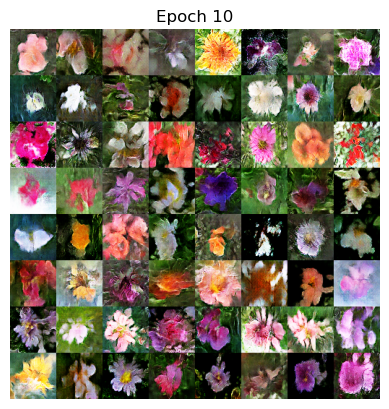

Epoch: 11
3304/3304
Epoch: 12
3304/3304
Epoch: 13
3304/3304
Epoch: 14
3304/3304
Epoch: 15
3304/3304
Epoch: 16
3304/3304
Epoch: 17
3304/3304
Epoch: 18
3304/3304
Epoch: 19
3304/3304
Epoch: 20
3304/3304


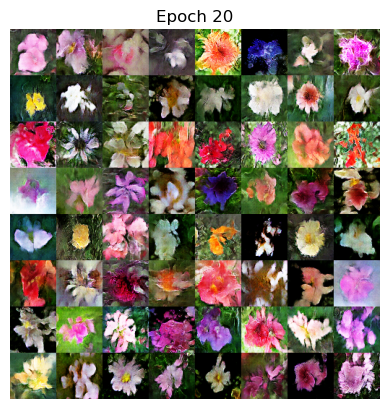

Epoch: 21
3304/3304
Epoch: 22
3304/3304
Epoch: 23
3304/3304
Epoch: 24
3304/3304
Epoch: 25
3304/3304
Epoch: 26
3304/3304
Epoch: 27
3304/3304
Epoch: 28
3304/3304
Epoch: 29
3304/3304
Epoch: 30
3304/3304


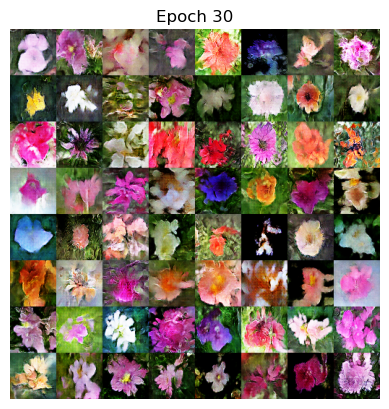

Epoch: 31
3304/3304
Epoch: 32
3304/3304
Epoch: 33
3304/3304
Epoch: 34
3304/3304
Epoch: 35
3304/3304
Epoch: 36
3304/3304
Epoch: 37
3304/3304
Epoch: 38
3304/3304
Epoch: 39
3304/3304
Epoch: 40
3304/3304


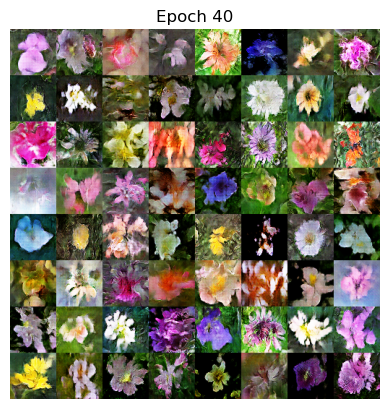

Epoch: 41
3304/3304
Epoch: 42
3304/3304
Epoch: 43
3304/3304
Epoch: 44
3304/3304
Epoch: 45
3304/3304
Epoch: 46
3304/3304
Epoch: 47
3304/3304
Epoch: 48
3304/3304
Epoch: 49
3304/3304
Epoch: 50
3304/3304


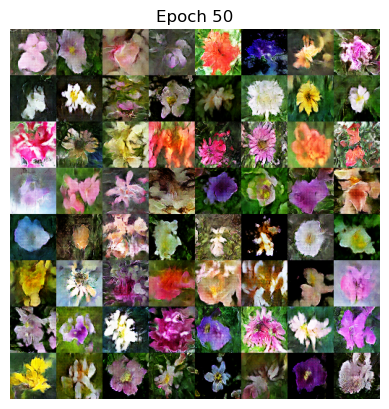

Epoch: 51
3304/3304
Epoch: 52
3304/3304
Epoch: 53
3304/3304
Epoch: 54
3304/3304
Epoch: 55
3304/3304
Epoch: 56
3304/3304
Epoch: 57
3304/3304
Epoch: 58
3304/3304
Epoch: 59
3304/3304
Epoch: 60
3304/3304


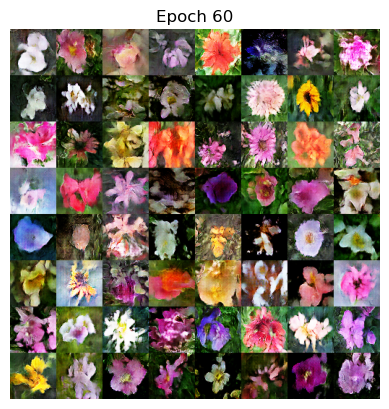

Epoch: 61
3304/3304
Epoch: 62
3304/3304
Epoch: 63
3304/3304
Epoch: 64
3304/3304
Epoch: 65
3304/3304
Epoch: 66
3304/3304
Epoch: 67
3304/3304
Epoch: 68
3304/3304
Epoch: 69
3304/3304
Epoch: 70
3304/3304


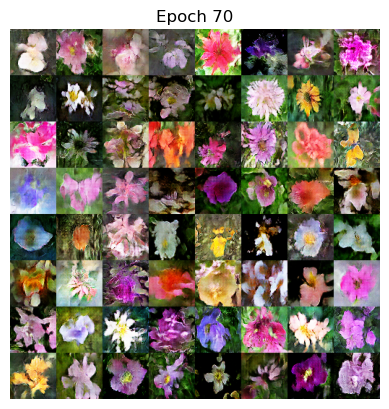

Epoch: 71
3304/3304
Epoch: 72


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/discriminator/conv2d_1/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Users\ccc87\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ccc87\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\ccc87\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ccc87\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\ccc87\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\ccc87\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ccc87\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\ccc87\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\ccc87\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ccc87\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ccc87\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ccc87\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ccc87\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\ccc87\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\ccc87\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ccc87\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\ccc87\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\ccc87\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ccc87\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ccc87\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\ccc87\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ccc87\AppData\Local\Temp\ipykernel_9696\1236010974.py", line 19, in <module>
      lg, ld = Train[ctr](real_img, embed, noise_decay)
    File "C:\Users\ccc87\AppData\Local\Temp\ipykernel_9696\3143094639.py", line 26, in DC_D_Train
      gradient_d = tp.gradient(ld, discriminator.trainable_variables)
Node: 'gradient_tape/discriminator/conv2d_1/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[64,32,32,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/discriminator/conv2d_1/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_DC_D_Train_1076554]

In [23]:
wlg = [None] * hparas['N_EPOCH'] #record loss of g for each epoch
wld = [None] * hparas['N_EPOCH']  #record loss of d for each epoch
# wsp = [None] * hparas['N_EPOCH']  #record sample images for each epoch

rsTrain = hparas['rs_Train']
ctr = 0
for ep in range(hparas['N_EPOCH']):
    print("Epoch: " + str(ep+1), end='\r')
    print('')
    lgt = 0.0
    ldt = 0.0
    if ep < 200:
        noise_decay = 1.0 / float(ep+1)
    else:
        noise_decay = 0.0
        
    for idx, (real_img,embed) in enumerate(dataset):
        print(str(idx+1) + '/' + str(hparas['N_SAMPLE']), end='\r')
        lg, ld = Train[ctr](real_img, embed, noise_decay)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == Critic : ctr = 0
    print('')
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    with open('./wlg_v2.txt','a') as f:
        f.write(str(lgt * rsTrain) + '\n')
    f.close()
    with open('./wld_v2.txt','a') as f:
        f.write(str(ldt * rsTrain) + '\n')
    f.close()
    
    out = test_step(test_noise, test_embed)
    img = utPuzzle(
        ((out+1) / 2. * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs_v2/w_%04d.png" % ep
    )
#     wsp[ep] = img
    if (ep+1) % 10 == 0: 
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %d" % (ep+1))
        plt.show()
    if (ep+1) % 10 == 0: 
        ckpt_manager.save()

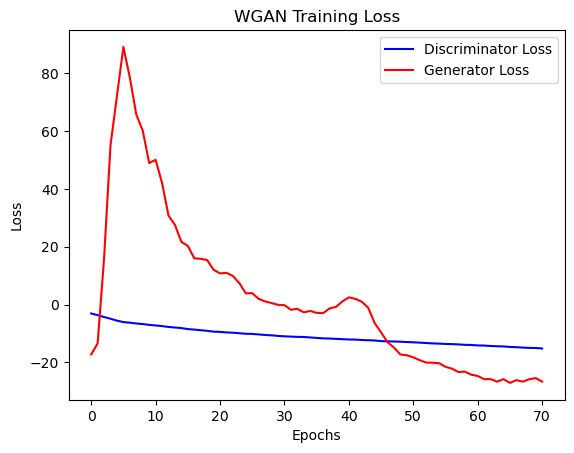

In [24]:
plt.plot(range(hparas['N_EPOCH']), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(hparas['N_EPOCH']), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

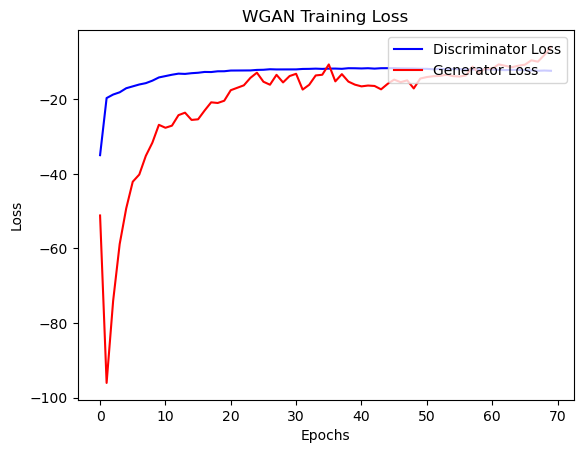

In [24]:
plt.plot(range(hparas['N_EPOCH']), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(hparas['N_EPOCH']), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

### Data with augmentation first try 280 epoch

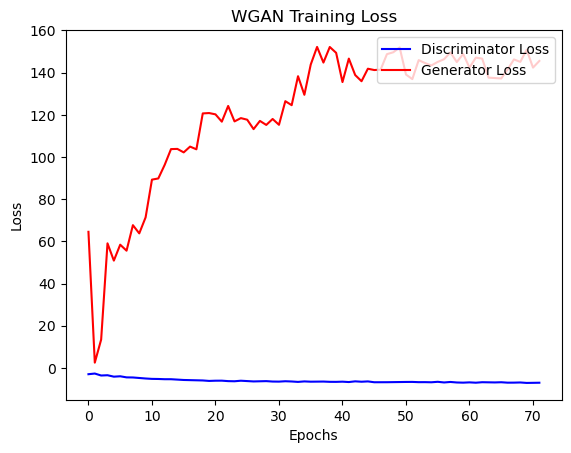

In [24]:
plt.plot(range(hparas['N_EPOCH']), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(hparas['N_EPOCH']), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

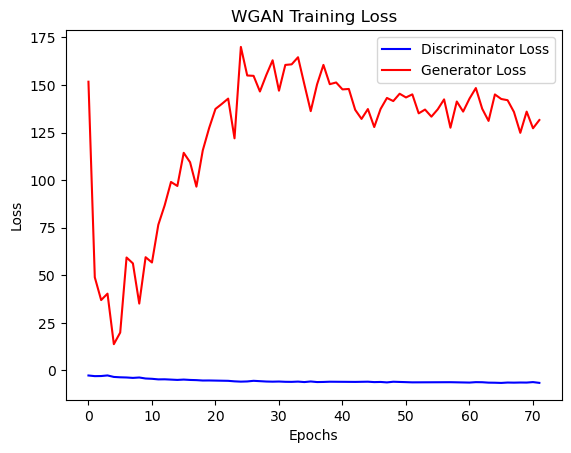

In [24]:
plt.plot(range(hparas['N_EPOCH']), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(hparas['N_EPOCH']), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

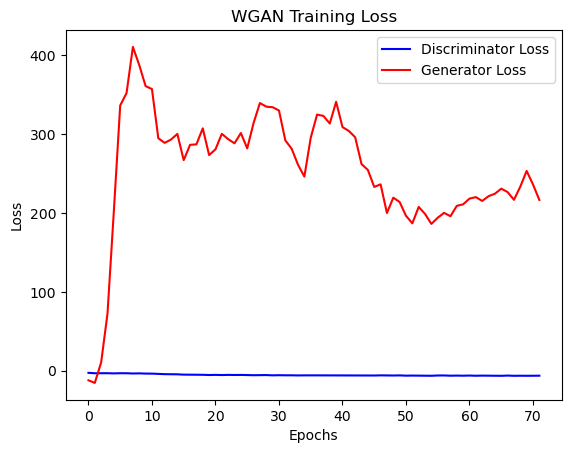

In [24]:
plt.plot(range(hparas['N_EPOCH']), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(hparas['N_EPOCH']), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

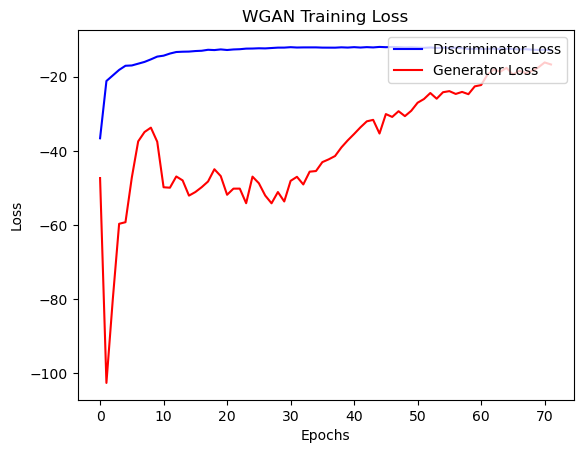

In [24]:
plt.plot(range(hparas['N_EPOCH']), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(hparas['N_EPOCH']), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()

### read testdata $

In [25]:
data = pd.read_pickle('./dataset/testData.pkl')

### preprocessing

In [10]:
def word2sent(indices_list):
    results_list = []
    for wordlist in indices_list:
        tmp = []
        tmp.append(wordlist)
        results_list.append(tmp)
    return results_list

In [11]:
data['Captions'] = data['Captions'].apply(lambda x: word2sent(x))

In [16]:
for i in range(len(data)):
    data['Captions'][i] = [data['Captions'][i]]

C:\Users\ccc87\AppData\Local\Temp\ipykernel_4624\3372737074.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Captions'][i] = [data['Captions'][i]]


In [23]:
data['texts'] = data['Captions'].apply(lambda x: idx2word(x))

In [27]:
from datetime import datetime

print("{}, start infering.".format(datetime.now()))
data['embeddings'] = data['texts'].apply(lambda x : turn_to_bert_embedding(x))
print("{}, end infering.".format(datetime.now()))

2022-12-19 11:09:42.117238, start infering.
2022-12-19 11:12:30.033059, end infering.


In [29]:
data['embeddings'].to_pickle('./testset/embedding.pkl')

In [30]:
data.to_pickle('./dataset/testData.pkl')

In [28]:
data

,ID,Captions,texts,embeddings
0,6735,"[[4, 12, 3, 16, 1, 5, 791, 2, 3, 78, 59, 5427,...",[this white and purple flower has fragile peta...,"[[0.08430960774421692, -0.12384727597236633, -..."
1,6740,"[[4, 1, 5, 158, 26, 64, 14, 2, 7, 12, 160, 3, ...",[this flower has four large wide pink petals w...,"[[-0.2721993327140808, -0.3047049641609192, -0..."
2,6746,"[[8, 1, 7, 157, 12, 3, 14, 454, 2, 3, 11, 19, ...",[a flower with broad white and pink ribbed pet...,"[[-0.2231108844280243, -0.3116427958011627, -0..."
3,6759,"[[91, 1643, 31, 7, 2369, 2370, 3, 45, 59, 7, 5...",[one prominet pistil with alarger stigam and m...,"[[-0.398025780916214, -0.3974345028400421, -0...."
4,6762,"[[53, 6, 21, 13, 18, 2, 6, 34, 14, 13, 18, 542...",[leaves are green in color petals are light pi...,"[[0.20599621534347534, -0.49965977668762207, 0..."
...,...,...,...,...
814,8000,"[[4, 1, 5, 8, 25, 22, 38, 7, 11, 103, 27, 61, ...",[this flower has a long orange petal with yell...,"[[-0.8912715315818787, -0.1303400993347168, -0..."
815,8012,"[[4, 1, 5, 25, 20, 2, 3, 25, 22, 30, 13, 9, 23...",[this flower has long red petals and long oran...,"[[-0.5348598957061768, -0.20177918672561646, -..."
816,8014,"[[4, 1, 5, 29, 11, 53, 7, 110, 22, 18, 79, 27,...",[this flower has bright yellow leaves with dee...,"[[-0.5727027654647827, -0.022602856159210205, ..."
817,8026,"[[4, 1, 15, 11, 3, 14, 13, 18, 7, 2, 10, 6, 10...",[this flower is yellow and pink in color with ...,"[[-0.08397945761680603, -0.20496295392513275, ..."


In [25]:
data['embeddings']

0      [[-0.15481653809547424, -0.17550793290138245, ...
1      [[-0.15481653809547424, -0.17550793290138245, ...
2      [[-0.009642578661441803, -0.8592413067817688, ...
3      [[-0.9724910259246826, -0.733251690864563, -0....
4      [[-0.4948228597640991, -0.8111581206321716, -0...
                             ...                        
814    [[-0.15481653809547424, -0.17550793290138245, ...
815    [[-0.15481653809547424, -0.17550793290138245, ...
816    [[-0.15481653809547424, -0.17550793290138245, ...
817    [[-0.15481653809547424, -0.17550793290138245, ...
818    [[-0.6443830132484436, -0.3861907124519348, 0....
Name: embeddings, Length: 819, dtype: object

### inference $

In [26]:
embeddings = data['embeddings'].values

embedding = []
id_for_dataset = []
for i in range(len(embeddings)):
    for emb in embeddings[i]:
        embedding.append(emb)
        id_for_dataset.append(data['ID'][i])
embedding = np.asarray(embedding)
test_noise = tf.random.normal(hparas['TEST_Z'])

In [27]:
len(embedding)

819

In [28]:
def testing_data_generator(ID, embedding):
    
    embedding = tf.cast(embedding, tf.float32)

    return ID, embedding

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((id_for_dataset, embedding))
dataset = dataset.map(testing_data_generator,num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.repeat(count=2).batch(BATCH_SIZE, drop_remainder=True)

In [30]:
if not os.path.exists('./inference/demo'):
    os.makedirs('./inference/demo')

In [31]:
ckpt.restore(ckpt_manager.latest_checkpoint)

In [35]:
ckpt.restore('./checkpoints/train/ckpt-19')

In [33]:
cnt = 0
for ID, embed in dataset:
    fake_image = test_step(test_noise, embed)
    for i in range(BATCH_SIZE):
        cnt += 1
        plt.imsave('./inference/demo/inference_{:04d}.jpg'.format(ID[i]), fake_image[i].numpy()*0.5 + 0.5)